# SBERT Zero Shot Learning Approach

In [1]:
import pandas as pd
import numpy as np

<h2>Loading SBERT</h2>

In [2]:
from sentence_transformers import SentenceTransformer

# Load a pretrained SBERT model
model_name = "paraphrase-mpnet-base-v2" # Compatible with 768 Dimensions to match BERT4RE
sbert = SentenceTransformer(model_name)

print("SBERT model loaded successfully.")

SBERT model loaded successfully.


<h2>Data Preprocessing</h2>

In [3]:
# Loading in promise dataset
df = pd.read_csv("datasets/promise.csv")

df.head()

,INPUT,TYPE
0,The system shall refresh the display every 60 ...,PE
1,The application shall match the color of the s...,LF
2,If projected the data must be readable. On a...,US
3,The product shall be available during normal b...,A
4,If projected the data must be understandable....,US


<h3>Re-Labeling</h3>

In [4]:
# Making dataset binary between functional & non-functional requirements

df.loc[df['TYPE'] != 'F', 'TYPE'] = 'NF' # Locating all values that do not equal 'F' and changing them to 'NF'

df.head(20)

,INPUT,TYPE
0,The system shall refresh the display every 60 ...,NF
1,The application shall match the color of the s...,NF
2,If projected the data must be readable. On a...,NF
3,The product shall be available during normal b...,NF
4,If projected the data must be understandable....,NF
5,The product shall ensure that it can only be a...,NF
6,The product shall be intuitive and self-explan...,NF
7,The product shall respond fast to keep up-to-d...,NF
8,The system shall have a MDI form that allows f...,F
9,The system shall display Events in a vertical ...,F


<h3>Lowercasing</h3>

In [5]:
df['INPUT'] = df['INPUT'].str.lower()

df.head()

,INPUT,TYPE
0,the system shall refresh the display every 60 ...,NF
1,the application shall match the color of the s...,NF
2,if projected the data must be readable. on a...,NF
3,the product shall be available during normal b...,NF
4,if projected the data must be understandable....,NF


<h3>Stopword Removal</h3>

In [6]:
#nltk.download('stopwords')
from nltk.corpus import stopwords

# Define stop words
stop_words = set(stopwords.words('english'))

# Function to remove stopwords
def remove_stopwords(text):
    words = text.split()  # Split the text into words
    filtered_text = ' '.join([word for word in words if word.lower() not in stop_words])
    return filtered_text

# Apply stopword removal to the DataFrame column
df['INPUT'] = df['INPUT'].apply(remove_stopwords)

df.head()

,INPUT,TYPE
0,system shall refresh display every 60 seconds.,NF
1,application shall match color schema set forth...,NF
2,projected data must readable. 10x10 projection...,NF
3,product shall available normal business hours....,NF
4,projected data must understandable. 10x10 proj...,NF


<h3>Punctuation Removal<h3>

In [7]:
import string

# Replacing percent symbol to string
df['INPUT'] = df['INPUT'].str.replace('%', ' percent')

# Remove punctuation from a specific column (e.g., 'Column1')
df['INPUT'] = df['INPUT'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)) if isinstance(x, str) else x)

df.head(20)

,INPUT,TYPE
0,system shall refresh display every 60 seconds,NF
1,application shall match color schema set forth...,NF
2,projected data must readable 10x10 projection ...,NF
3,product shall available normal business hours ...,NF
4,projected data must understandable 10x10 proje...,NF
5,product shall ensure accessed authorized users...,NF
6,product shall intuitive selfexplanatory 90 pe...,NF
7,product shall respond fast keep uptodate data ...,NF
8,system shall mdi form allows viewing graph dat...,F
9,system shall display events vertical table time,F


<h3>Dataset Proportion</h3>

In [8]:
# Count the number of F and NF in the dataset
label_counts = df['TYPE'].value_counts()

print("Number of Functional (F) requirements:", label_counts.get('F', 0))
print("Number of Non-Functional (NF) requirements:", label_counts.get('NF', 0))

Number of Functional (F) requirements: 255
Number of Non-Functional (NF) requirements: 370


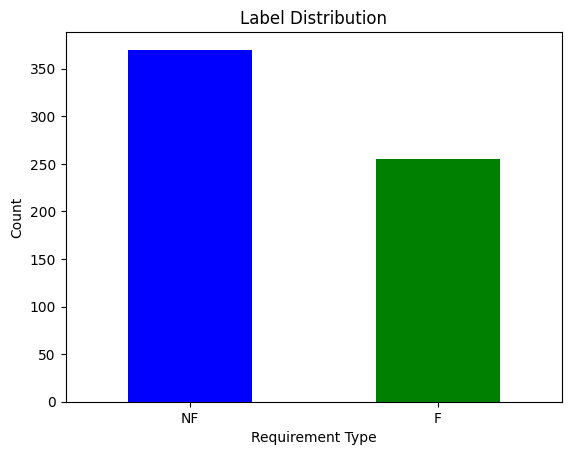

In [9]:
import matplotlib.pyplot as plt

# Plot a bar chart of label distribution
label_counts.plot(kind='bar', color=['blue', 'green'])
plt.title("Label Distribution")
plt.xlabel("Requirement Type")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

<h2>SBERT Fitting<h2>

<h3>Label Descriptions</h3>

In [11]:
label_descriptions = {
    "functional": {
        "Represents a specific behavior or feature that the system is required to perform.",
        "Describes actions the software must execute to fulfill business processes or user needs.",
        "Defines explicit functionalities that contribute directly to achieving system objectives.",
        "Focuses on 'what' the system does, including data processing, computations, and workflows.",
        "Specifies system features that interact with users, data, or external systems to deliver value.",
        "Describes user-requested tasks or operations that align with the intended application scope.",
        "Outlines step-by-step actions or features essential for completing user tasks or business goals."
    },
    "non_functional": {
        "Defines the standards and conditions under which the system operates to ensure quality.",
        "Specifies criteria such as performance, security, and usability that guide system operations.",
        "Focuses on 'how' the system performs its tasks, including efficiency and reliability constraints.",
        "Outlines measurable attributes like scalability, availability, and maintainability.",
        "Describes system properties that ensure operational consistency and user satisfaction.",
        "States operational benchmarks for system behavior, such as latency, error tolerance, or throughput.",
        "Defines quality-of-service metrics and compliance standards the system must achieve."
    }
}

<h3>SBERT Label Embeddings</h3>

In [13]:
import torch
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute SBERT embeddings for each label description
sbert_label_embeddings = {
    label: [sbert.encode(desc, convert_to_tensor=True).to(device) for desc in descriptions]
    for label, descriptions in label_descriptions.items()
}

# Calculate intra-label cosine similarities
intra_label_similarity = {}

for label, embeddings in sbert_label_embeddings.items():
    # Convert embeddings to numpy arrays
    embeddings_np = [embedding.detach().cpu().numpy() for embedding in embeddings]
    
    # Compute pairwise cosine similarities
    pairwise_sim = cosine_similarity(embeddings_np)
    
    # Extract the upper triangle of the similarity matrix (excluding diagonal)
    upper_triangle = pairwise_sim[np.triu_indices_from(pairwise_sim, k=1)]
    
    # Compute the mean similarity for the label
    intra_label_similarity[label] = upper_triangle.mean()

    print(f"Mean intra-label cosine similarity for {label}: {intra_label_similarity[label]:.4f}")

# Compute inter-label cosine similarity (F vs NF)
# Compute inter-label cosine similarity (functional vs non-functional)
f_embedding = torch.stack(sbert_label_embeddings["functional"]).mean(dim=0).detach().cpu().numpy()
nf_embedding = torch.stack(sbert_label_embeddings["non_functional"]).mean(dim=0).detach().cpu().numpy()
cos_sim_inter = cosine_similarity([f_embedding], [nf_embedding])[0][0]

print(f"\nCosine similarity between SBERT functional and non-functional embeddings: {cos_sim_inter:.4f}")

Mean intra-label cosine similarity for functional: 0.5928
Mean intra-label cosine similarity for non_functional: 0.5800

Cosine similarity between SBERT functional and non-functional embeddings: 0.7317


<h3>SBERT Requirements Embeddings<h3>

In [15]:
# Compute embeddings for the requirements
requirement_embeddings = [
    sbert.encode(requirement, convert_to_tensor=True).detach().cpu().numpy()
    for requirement in df['INPUT']
]

<h2>Model Evaluation<h2>

In [17]:
from sklearn.metrics import classification_report

# Function to calculate cosine similarity
def cosine_similarity_single(vec1, vec2):
    vec1 = torch.tensor(vec1, dtype=torch.float32)
    vec2 = torch.tensor(vec2, dtype=torch.float32)
    return torch.nn.functional.cosine_similarity(vec1, vec2, dim=0).item()

# Compute predictions based on cosine similarity
predicted_labels = []
for req_embedding in requirement_embeddings:
    # Calculate similarity with functional and non-functional label embeddings
    functional_sim = np.mean([cosine_similarity_single(req_embedding, label_emb) 
                              for label_emb in sbert_label_embeddings["functional"]])
    non_functional_sim = np.mean([cosine_similarity_single(req_embedding, label_emb) 
                                  for label_emb in sbert_label_embeddings["non_functional"]])

    # Assign the label with the highest similarity
    predicted_labels.append("F" if functional_sim > non_functional_sim else "NF")

# Add predictions to the DataFrame
df['Predicted_Label'] = predicted_labels

# Generate classification report
report = classification_report(df['TYPE'], df['Predicted_Label'], target_names=["F", "NF"])
print(report)

/tmp/ipykernel_64106/2520218575.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vec2 = torch.tensor(vec2, dtype=torch.float32)


              precision    recall  f1-score   support

           F       0.52      0.57      0.54       255
          NF       0.68      0.63      0.66       370

    accuracy                           0.61       625
   macro avg       0.60      0.60      0.60       625
weighted avg       0.62      0.61      0.61       625

